# Lab 7: Gradient Descent





In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


In [27]:
%matplotlib notebook
from pylab import *
import numpy.linalg as LA

def draw_path(func,path,x_min=-2,x_max=2,y_min=-2,y_max=2):
    path=np.array(path)
    a=np.linspace(x_min,x_max,100)
    b=np.linspace(y_min,y_max,100)
    x,y=np.meshgrid(a,b)
    z=func((x,y))
    fig,ax=plt.subplots()
    my_contour=ax.contour(x,y,z,50)
    plt.colorbar(my_contour)
    ax.plot(path[:,0],path[:,1])
    ax.scatter(path[-1,0],path[-1,1],color = 'r', marker = '*',label = 'Function Minimimum')
    print("path length:",len(res['path']))
    

In [40]:
def statistics_test(method,args,times,global_minimum=None):
    result=[]
    for n in range(times):
        res=method(*args)
        if not global_minimum==None and LA.norm(res['x']-global_minimum)>1e-3:
            continue
        result.append(len(res['path']))
    if len(result)>0:
        avg=np.average(result)
        var=np.std(result)
        print("Running %d times: reach global minimum %d times, average %d steps with variance %f"%(times,len(result),avg,var))
    else:
        print("Running %d times: reach global minimum %d times"%(times,0))




# Gradient Descent

We explored in the last lab why `scipy.optimize.minimize` or `sklearn.LinearRegression` works with redundant features when an analytical solution fails above. This is because `scipy.optimize.minimize` and `sklearn.LinearRegression` use numerical optimization techniques to find **a** solution---it does not require a unique solution through matrix inverses. 

 Below, we explore a numerical optimization method called **gradient descent**. It is a simpler version of the default solver used by `scipy.optimize.minimize` and `sklearn.LinearRegression`. 

## Question 1: The Rosebrock Banana Function

<img src='rb.png' width="600px" />

Rosenbrock banana function
$f(x,y)=(1-x)^2+10(y-x^2)^2$

In [10]:
def Rosenbrock(X):
    x,y=X
    return (1-x)**2+10*(y-x**2)**2



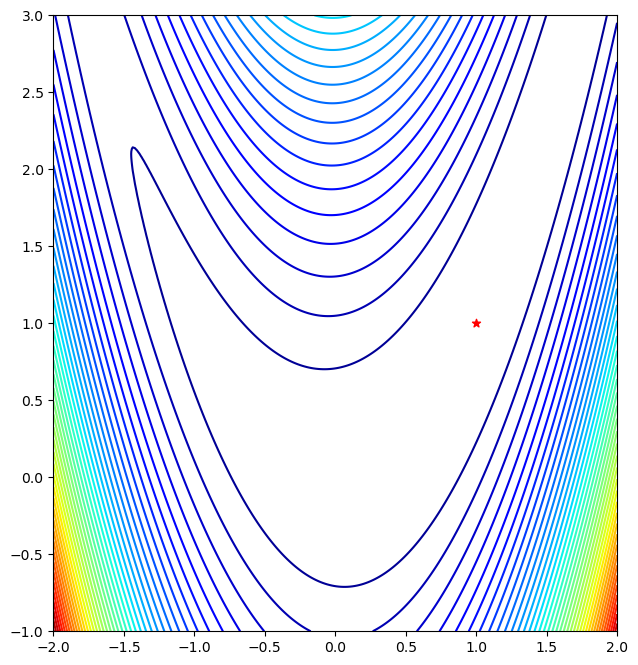

In [12]:
x = np.linspace(-2,2,250)
y = np.linspace(-1,3,250)
X, Y = np.meshgrid(x, y)
X_in = np.array([X,Y])
Z = Rosenbrock(X_in)
%matplotlib inline
fig = plt.figure(figsize = (16,8))
#Contour plot
ax = fig.add_subplot(1, 2, 2)
ax.contour(X,Y,Z, 50, cmap = 'jet')
ax.scatter(1.0,1.0,color = 'r', marker = '*',label = 'Function Minimimum')

Let's now implement gradient descent. 

We saw in lecture that the gradient descent update function follows the form:

$$\large
\vec{\theta}^{(t+1)} \leftarrow \vec{\theta}^{(t)} - \alpha \left (\nabla_\vec{\theta} L(\vec{\theta}, \mathbb{X}, \mathbb{Y}) \right )
$$
where 

- $\vec{\theta}^{(t+1)}$: Our new coefficients after making an update.
- $\vec{\theta}^{(t)}$: Our current coefficients.
- $\alpha$: Our step size or learning rate.
- $\nabla_\vec{\theta} L(\vec{\theta}, \mathbb{X}, \mathbb{Y})$: The gradient of our loss.

At each time step, use the gradient and `alpha` to update your current `theta`. 


The point I'd like to illustrate is that our loss function,
$$\large
(L(\vec{\theta}, \mathbb{X}, \mathbb{Y}))
$$

is just what it sounds like, a basic mathematical function. It's definition and subsequent derivative / gradient evaluation gets more complicated in our regression models and as we eventually expand to neural networks, but the point is: as long we can define a function and it's derivatives, we can iteratively solve for a numerical solution using the gradient descent algorithm.


### Question 1a 
#### Rosenbrock Gradient

Since the Rosenbrock function $f(\mathbb{X})$ is taking the place of our loss function $(L(\vec{\theta}, \mathbb{X}, \mathbb{Y}))$, we need a way to evaluate it's corresponding gradient $\nabla_\vec{\mathbb{X}} f(\mathbb{X})$

In thise case our input $\mathbb{X}$ is a 2-d array (x,y) values, so our corresponding gradient should share the same shape.

In [15]:
def Rosenbrock_grad(X):
    x,y=X
    dx=2*(x-1)+20*(y-x**2)*(-2*x)
    dy=20*(y-x**2)
    return np.array([dx,dy])

In [48]:
def gradient_descent(func,first_derivate,starting_point,stepsize,tol=1e-5):
    deriv=first_derivate(starting_point)
    count=0
    visited=[]
    while LA.norm(deriv)>tol and count<1e5:
        new_point=starting_point-stepsize*deriv
        if func(new_point)<func(starting_point):
            visited.append(starting_point)
            starting_point=new_point
            deriv=first_derivate(starting_point)
            stepsize*=1.2
            count+=1
            
        else:
            stepsize/=2
            count+=1
    return {"x":starting_point,"evaluation":func(starting_point),"path":visited}

In [49]:
original_point=np.array([-0.5,1.5])
res=gradient_descent(Rosenbrock,Rosenbrock_grad,original_point,0.1,1e-5)

path length: 1204


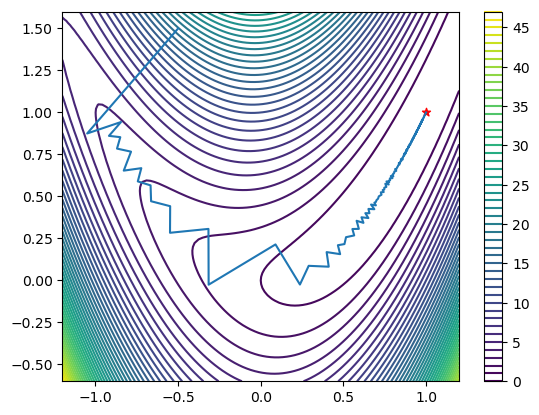

In [50]:
draw_path(Rosenbrock,res['path'],-1.2,1.2,-0.6,1.6)

If done correctly the gradient descent method should have reached the minimum in around ~1200 steps. Let's compare to a built in scipy method `BFGS`, which is a psuedo-2nd order method that uses information of the Hessian (2nd derivative for vectors / tensors, gradient is first derivative) to optimize a given function.

In [32]:
from scipy.optimize import minimize

res=minimize(Rosenbrock,original_point,method='BFGS',jac=Rosenbrock_grad,options={"gtol":1e-5,"disp":True})
print(res.x)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 22
         Function evaluations: 31
         Gradient evaluations: 31
[1.00000004 1.00000009]


### Question 1b
The minimization of Rosenbrock banana function is much faster here compared to our own gradient descent code. Why did our method take so many more steps? Give your best explanation below **Hint - look at gradient descent path** 

_Type your answer here, replacing this text._

## Question 2: The Mishra's Bird Function Function

$f(x,y)=-(sin(y) exp((1-cos(x))^2+cos(x) exp((1-sin(y))^2)+(x-y)^2)$

Mishra's Bird is another complex 2-d function, but differs from the previous case in that there are several local minima and maxima to get stuck on.


In [37]:
def Mishra(X):
    x,y=X
    return -(np.sin(y)*np.exp((1-np.cos(x))**2)+np.cos(x)*np.exp((1-np.sin(y))**2)+(x-y)**2)

def Mishra_grad(X):
    x,y=X
    dx=-(np.sin(y)*np.exp((1-np.cos(x))**2)*2*(1-np.cos(x))*np.sin(x)-np.exp((1-np.sin(y))**2)*np.sin(x)+2*(x-y))
    dy=-(np.exp((1-np.cos(x))**2)*np.cos(y)+np.exp((1-np.sin(y))**2)*np.cos(x)*2*(1-np.sin(y))*(-np.cos(y))-2*(x-y))
    return np.array([dx,dy])

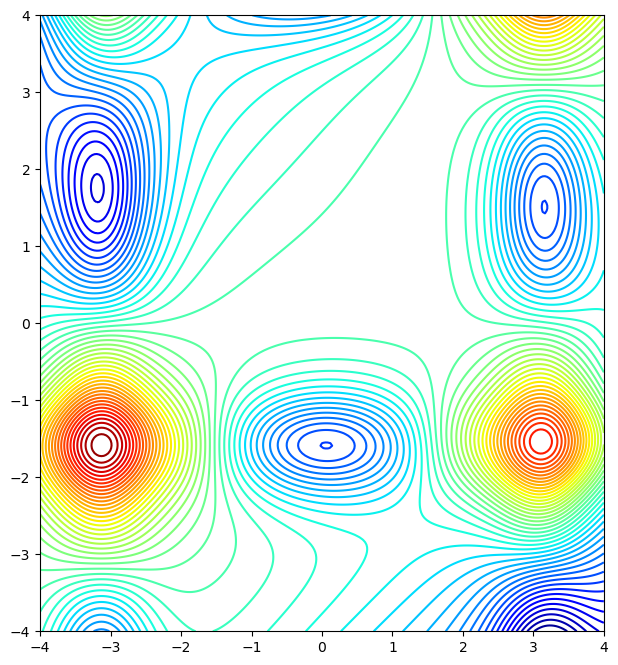

In [39]:
x = np.linspace(-4,4,250)
y = np.linspace(-4,4,250)
X, Y = np.meshgrid(x, y)
X_in = np.array([X,Y])
Z = Mishra(X_in)
%matplotlib inline
fig = plt.figure(figsize = (16,8))
#Contour plot
ax = fig.add_subplot(1, 2, 2)
ax.contour(X,Y,Z, 50, cmap = 'jet')

How well does our gradient descent approach work on this function?

path length: 32


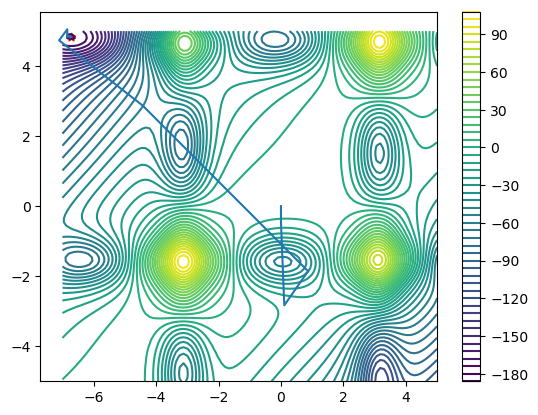

In [62]:
original_point=np.array([0,0])
res=gradient_descent(Mishra,Mishra_grad,original_point,0.1,1e-5)
draw_path(Mishra,res['path'],-7,5,-5,5)

Our code ran pretty quik - but it did not reach the actual minimum. Let's make some improvements.

Stochastic Gradient Descent with Momentum (SGDM) is a variant of gradient descent that adds two components to the algorithim:

1) Stochastic noise modifies the calculated gradient direction

2) Subsequent steps in 'similar' directions add adaptive momentum to the model, increasing the step size

In [44]:
def SGDM(func,first_derivate,starting_point,stepsize,momentum=0,tol=1e-5,stochastic_injection=0):
    deriv=first_derivate(starting_point)
    count=0
    visited=[]
    previous_direction=np.zeros(len(starting_point))
    while LA.norm(deriv)>tol and count<1e5:
        if stochastic_injection>0:
            random_vector=np.random.random(len(starting_point))*2-1
            stochastic_deriv=LA.norm(deriv)*random_vector/LA.norm(random_vector)
        else:
            stochastic_deriv=np.zeros(len(starting_point))
        direction=-(deriv+stochastic_injection*stochastic_deriv)
        new_point=starting_point+stepsize*(momentum*previous_direction+direction)

        if func(new_point)<func(starting_point):
            visited.append(starting_point)
            starting_point=new_point
            previous_direction=direction+momentum*previous_direction
            deriv=first_derivate(starting_point)
            stepsize*=1.2
            count+=1
            
        else:
            if stepsize<1e-5:
                previous_direction=previous_direction-previous_direction
            else:
                stepsize/=2
            count+=1
    return {"x":starting_point,"evaluation":func(starting_point),"path":visited}

path length: 75
[-3.18807081  1.75349885] -76.8779893930294


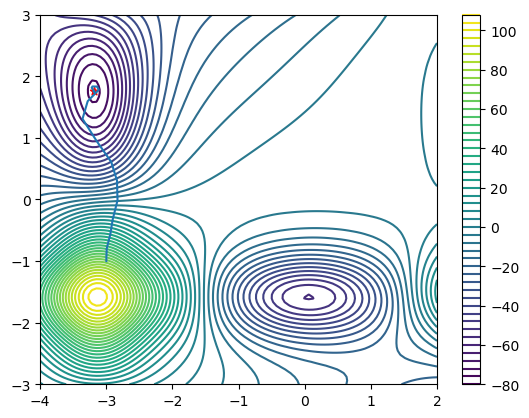

In [63]:
original_point=np.array([-3,-1])
res=SGDM(Mishra,Mishra_grad,original_point,0.001,0.5,1e-5,0.3)
draw_path(Mishra,res['path'],-4,2,-3,3)
print(res['x'],res['evaluation'])

### Question 2a

With randomness added into our optimaztion model we can no longer rely on a single example. Use the `statistics_test` function defined above to get the results of running SGDM ~20 times. 

In [64]:
statistics_test(...)

Ellipsis